# Problema de Regressao

# 1- Introducao

O Problema de regressao abordado em sequencia tem como objetivo prever os preços futuros das ações da empresa petrobras (PETR4)
com base em seus preços históricos passados.
Daremos início a implementação a partir de dois arquivos datasets CSV nomeados como:

>### Train - petr4_treinamento.CSV;
### Test - ptr4_teste.CSV;

O dataset train que estaremos utilizando possuem exatamente 1245 linhas e 7 colunas. Que equivalem aos precos passados e dados do mercado financeiro.
Começaremos realizando a limpeza dos dados, logo em seguida a conversao dos dados de acordo com os nosso criterios e finalizando a limpeza dos mesmos.
Implementaremos o modelo de rede neural concorrentes(Temporais) com base em seus conceitos, mais precisamente a rede neural LSTM (long-short term memory).
Partiremos da premisa que o leitor ja é sabido em relacao aos conceitos, finalizando com o o treinamento e previsao dos precos.
Ja a validação, convido ao leitor a testar e validar com dados novos.

In [4]:
# Importamos as Bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn, optim
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
# Fixando os dados aleatorios que serao gerados
torch.manual_seed(123)
%matplotlib inline

# 2-Tratamento dos dados

Para podermos tratar os dados da melhor forma possivel e que não resulte de forma negativa na previsao de nosso modelo, 
seguiremos a seguintes etapas:
> * ### 2.1 - Carregamento dos dados no dataset petr4_treinamento.csv;
* ### 2.2 - Limpeza dos dados nulos e verificação das falhas nos dados;
* ### 2.3 - Normalizacao dos dados. Ou seja, utilizaresmos a biblioteca MinMaxScaler para mapear os dados entre 0 e 1;
* ### 2.4 - Conversao dos dados de pandas => array => tensor, sequencialmente;
* ### 2.5 - Implementação do modelo;
* ### 2.6 - Treinamento do modelo;
* ### 2.7 - Carregamento dos dados no dataset petr4_teste.csv>

2.1 - Carregamento dos dados no dataset petr4_treinamento.csv;

In [5]:
# Carregando a os dados do aquivo petr4_treinamento.csv
base = pd.read_csv('C:\\Users\\jefferson.maria\\Desktop\\Neural_Network_PyTorch\\Temporal\\Data\\petr4_treinamento.csv')

In [6]:
# Obtendo os 5 primeiros dados
base.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [7]:
print(base.shape)

(1245, 7)


In [8]:
# Verificando os dados nulos que estao em cada coluna
print(base.isnull().sum())

Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64


2.2 - Limpeza dos dados nulos e verificação das falhas nos dados;
>Precisamos sempre verificar se o nosso dataset possui algum dado nulo, pois se nao tratarmos o nosso modelo não sera calpaz de calcular e retornará um erro,
portanto usamos a biblioteca do pandas e as class **.isnull()**, que ira passar por cada coluna no dataset e ira pergunta - lo, 'tens alguma linha nula?', entao retornara tera como retorno **True** para as linhas que sao nulas e **False** para as linhas que nao sao nulas. Portando, como teremos uma tabela com linhas true e false, entao para facilizar nosso entendimento, acrescentamos o metodo **sum()** para somar todas linhas falsas e retornara o valor total de cada coluna.
Logo mais, plotamos o grafico de calor (**heatmap()**) da biblioteca **seaborn()** para que de forma visual posssamos concluir nossa analise. Para resolvermos o
nosso problema com os dados nulos, como verificamos sao poucas linhas, entao vamos excluir todas as linhas que possuem algum dado nulo, porque nao tera tanto empacto na decisao do nosso modelo.
>Observacao: Para podermos plotar com exito utilizando o grafico .heatmap(), não podemos utilizar a soma dos dados nulos de cada coluna, e sim, indentificar os dados nulos e logo em seguida, plotar - los.

In [9]:
x = base.isnull()

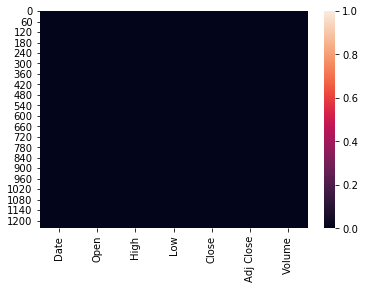

In [19]:
#Plotando os dados nulos 1 para true e 0 falso
sns.heatmap( x, vmin= 0, vmax= 1)

In [10]:
# Removendo os dados nulos
base = base.dropna()

In [11]:
print(base.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


Portanto depois de resolvermos o problema com os dados nulos, a proxima etapa, será declarar nossos dados de treinamento, que sera utilizado para treinarmos a nossa rede neural ( LSTM ). Tendo isso como proposito e depois de analisarmos todos os dados, vamos utlizar o metodo .iloc() que passaremos como parametros os index das colunas e linhas que estaremos utilizando a prior em nossa LSTM. Usaremos a coluna **open**(index= 1:2), e todos as suas linhhas(index= :);

In [12]:
# Obtendo todas as linhas da coluna 1
data_train = base.iloc[ :, 1:2]
print(data_train.head)

<bound method NDFrame.head of            Open
0     19.990000
1     19.809999
2     20.330000
3     20.480000
4     20.110001
...         ...
1240  15.750000
1241  15.750000
1242  15.990000
1243  16.100000
1244  16.100000

[1242 rows x 1 columns]>


2.3 - Normalizacao dos dados. Ou seja, utilizaresmos a biblioteca MinMaxScaler para mapear os dados entre 0 e 1;

>Opaaa! Nos deparamos com dados muiito altos... o que pode resultar em calculos muito altos que podem exigir muito do nosso poder computacional, 
entao vamos mapear todas as linhas do nosso dados de treinamento para que o valor fique entre 0 e 1.
Para isso, vamos utilizar o Metodo **MinMaxScaler()** da biblioteca **sklearn.preprocessing** e passaremos como parametro a margem maxima e minima do nosso mapeamento e transformara os dados do **tipo pandas** para o tipo **array**. Por fim, para finalizar nossa analise e preparacao dos dados de treinanemnto, 
realizamos uma plotagem simples... onde o **eixo x= sao cada dados unitarios** e o **eixo y= valores de cada dado.**

In [13]:
# a grosso modo estamos Transformando os dados de pandas para array, de dados entre 0 e 1
normalizador = MinMaxScaler( feature_range= (0, 1))
print(type(data_train))
data_train_normalized =  normalizador.fit_transform( data_train )
print(type(data_train_normalized))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [14]:
#visualizamos os dados mapeados entre zero e um
print(data_train_normalized)

[[0.76501938]
 [0.7562984 ]
 [0.78149225]
 ...
 [0.57122093]
 [0.57655039]
 [0.57655039]]


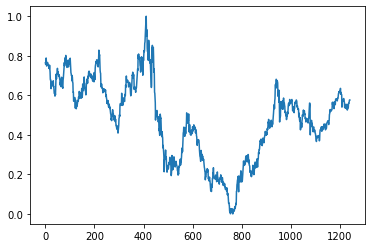

In [15]:
#Platamos um grafico simples para concluir nossa analise...
plt.plot( data_train_normalized )

2.3 Definindo o nosso Time Steps e realizando a conversao dos dados de pandas => array => tensor, sequencialmente;
>Nessa etapa realizamos as seguintes etapas, como agora possuimos a variavel *data_train_normalized* mapeada entre 0 e 1, portanto, agora devemos declarar o nosso **time_steps**, ou seja, segundo os conceitos basicos de uma rede neural LSTM e a grasso modo, a nossa tempo de amostras?, intervalo de tempo?, enfim, o tempo que usaremos para porever o preco da acao. Usaremos o intervalo de tempo de 90 dias. OU seja, usamos 90 valores anteriores a nossa previsao. Portanto, obteremos os nossos 90 valores e com ele calculmos a nossa previsao, que sera o numero 91, depois mais 90 dias e nossa previsao sera no 182 dias. Para isso, usamos o for para percorer todos os dados da lista, partindo da posicao 90 e percorrer ate a posicao final da lista (1242). Entretanto, possuimos duas variaveis, **X** e **y**, duas listas vazias. A cada 90 valores adicionados na lista **x**, o proximo seria a nossa variavel de previsao, portanto sera armazenada em nossa variavel y ( target ), a variavel que queremos prever, e assim analogamente. Logo, depois de obtermos todos os nossos dados e separados em dados de treino e dados de previsao, convertemos nossos dados do tipo array para o tipo tensor.

In [16]:
# VARIAVEL X SAO OS PREVISORES e Y sera os precoes reais, comecamos na posicao 90, 0 = por ter apenas uma coluna na matriz 
X = []
Y = []
for i in range(90, 1242):
    X.append(data_train_normalized[i-90:i, 0])
    Y.append(data_train_normalized[i, 0])
X, Y = np.array( X ), np.array( Y )

In [19]:
# os Noventa dados anteriores
X[0]

array([0.76501938, 0.7562984 , 0.78149225, 0.78875969, 0.77083338,
       0.74806197, 0.75436047, 0.75823643, 0.76598837, 0.76598837,
       0.76017437, 0.75872098, 0.75581391, 0.74467054, 0.7374031 ,
       0.7374031 , 0.73498067, 0.75242248, 0.73401163, 0.71656977,
       0.68120155, 0.67538755, 0.67635659, 0.63372098, 0.66521318,
       0.65649225, 0.64680228, 0.66618222, 0.65843028, 0.64970935,
       0.65116274, 0.66424419, 0.67344961, 0.64292631, 0.64486434,
       0.62257747, 0.60949617, 0.60998067, 0.60852713, 0.59593023,
       0.61143411, 0.60222863, 0.64922481, 0.68362398, 0.70687989,
       0.68265509, 0.70978682, 0.70784879, 0.71608527, 0.73643411,
       0.7122093 , 0.7122093 , 0.7194767 , 0.70348832, 0.69525189,
       0.70397287, 0.70397287, 0.69767442, 0.68168605, 0.68168605,
       0.65310078, 0.66618222, 0.64825581, 0.66182175, 0.64341085,
       0.67877902, 0.69137592, 0.66569772, 0.65406982, 0.64292631,
       0.64147292, 0.63565891, 0.67587209, 0.68653106, 0.70300

In [17]:
# Proximo Valor real
Y[0]

0.7611434108527131

In [18]:
#Convertendo para tensor
X = torch.tensor( X, dtype= torch.float32)
Y = torch.tensor( Y, dtype= torch.float32)

In [19]:
# concatenando os dois datasets e definindo o batch_size= 32 shuffle= True para misturar a cada bach_size selecionado
datasets = torch.utils.data.TensorDataset(X, Y)
loader = torch.utils.data.DataLoader(datasets, batch_size= 32, shuffle= True)

2.5 - Implementação do modelo
>Na Implementação do modelo da nossa rede neural LSTM() comecamos com a declaracao da classe e utilizamos uma biblioteca do pytorch.nn nomeada de LSMT, passamos por parametro:
* Input_size => Que é a quantidade de dimensoes de cada entrada de dados no time_step, lembra?, como os nossos dados so tem uma dimensao, entao = 1.
* hidden_size => Equivale a quantod desdobramentos a rede neural ira fazer, no nosso caso sera igua a 100, porem nao tem um valor especifico.
* Num_layers => Equivale a dimensoes da lstm, ou seja, é como se fosse uma cama sonbreposto da outra camada, entao, a LSMT3 - tera duas camadas
Entretando, depois de construirmos a nossa rede neural, com uma camada de entrada, duas camadas ocultas a camada de saida sera uma camada densa normal com 50 dados de entrada e uma de saida, que para o nosso problema eequivale ao preço previsto.

>No metodo **Foward** iniciamos revertendo as entradas com o **permute(1,0)** e **usqueeze( 2 )**. Ou seja, permute esta invertendo os dados de entrada, esta entrando 0,1 colunas e esta sendo convertido para 1,0 ordem das colunas. **(batch_size, timesteps) -> (timesteps, batch_size, dimensions)**
Como a cada time_step ele retornara uma previsao e nós queremos somente a ultima posicao, entao antes de retornarmos X, declaramos **x = [-1]** que define que queremos apenas a ultima posicao da lista retornada em X

In [20]:
class Regressor_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        # inputsize ´r a dimensao que cada dado tem no seu time_step
        self.lstm1 = nn.LSTM(input_size= 1, hidden_size= 100)
        self.lstm2 = nn.LSTM(input_size= 100, hidden_size= 50)
        # Num_layers é a quantidade de camada que a lstm tera
        self.lstm3 = nn.LSTM(input_size= 50, hidden_size= 50, dropout= 0.3, num_layers= 2)
        self.dropout = nn.Dropout( 0.3 )
        self.linear = nn.Linear(in_features= 50, out_features= 1)
    
    def forward(self, X ):
        X = X.permute(1, 0).unsqueeze( 2 )
        X, _ = self.lstm1( X )
        X = self.dropout( X )
        X, _ = self.lstm2( X )
        X = self.dropout( X )
        X, _ = self.lstm3( X )

        X = X[ -1 ]
        X = self.dropout( X )
        X = self.linear( X )

        return X

In [21]:
# Verificamos se a maquina possui uma GPU, se nao possui retorna cpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [22]:
print( device )

cpu


Definimos como criterio para se calcular a perda do treinamento e atualizacao dos pesos o metodo *MSELoss* que retorna a media da perda.
Deixo aqui a proposta de conhcer a formula matematica por tras do mean squared error, caso o leitor nao conheça.

Como optimizador( normalizador do gradiente ) opitamos pelo RMSprop que passaremos taxa de aprendizagem(lr= 1e-3, alpha= 0.9)

In [2]:
regressor = Regressor_LSTM()
regressor.load_state_dict(torch.load('C:\\Users\\jefferson.maria\\Desktop\\Neural_Network_PyTorch\\Temporal\\checkpoint.pth'))
criterion = nn.MSELoss()
optimizer =  optim.RMSprop(params= regressor.parameters(), lr= 1e-3, alpha= 0.9)

NameError: name 'Regressor_LSTM' is not defined

In [80]:
print(regressor)

Regressor_LSTM(
  (lstm1): LSTM(1, 100)
  (lstm2): LSTM(100, 50)
  (lstm3): LSTM(50, 50, num_layers=2, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


2.6 - Treinamento do modelo
Na etapa de Treinamento do nosso modelo, criamos uma funcao aninhada que possui dois fors, onde a partir das epochas definidas, podemos calular os pesos e depois atualizar-los para podemos alcançar o melhor Treinamento possivel.

In [81]:
for epoch in range( 20 ):
    running_loss = 0.
    running_mea = 0.

    for index, data in enumerate( loader ):
        inputs, labels = data
        inputs, labels =  inputs.to( device ), labels.to( device )


        optimizer.zero_grad()

        outputs = regressor( inputs )
        outputs = outputs.flatten()

        loss = criterion( outputs, labels )
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        mea = mean_absolute_error( labels.detach().cpu().numpy().flatten(), outputs.detach().cpu().numpy().flatten() )

        running_mea += mea

        print('\rEpoch:{:3d} \t Loop: {:3d} in {:3d} \t loss: {:03.5f} \t Mean Absolute Error: {:03.5f}'.format(epoch + 1, index + 1, len( loader), loss, mea ), end='\r')

    running_loss /= len( loader )
    running_mea /= len( loader )
    print('Epoch: {:3d} Finished - loss {:03.6f} - Mean Absolute Error {:03.6f}'.format( epoch+1, running_loss, running_mea ))


Epoch:   1 Finished - loss 0.001642 - Mean Absolute Error 0.029391
Epoch:   2 Finished - loss 0.001478 - Mean Absolute Error 0.028181
Epoch:   3 Finished - loss 0.001418 - Mean Absolute Error 0.027890
Epoch:   4 Finished - loss 0.001425 - Mean Absolute Error 0.028479
Epoch:   5 Finished - loss 0.001464 - Mean Absolute Error 0.028558
Epoch:   6 Finished - loss 0.001276 - Mean Absolute Error 0.025989
Epoch:   7 Finished - loss 0.001397 - Mean Absolute Error 0.027748
Epoch:   8 Finished - loss 0.001366 - Mean Absolute Error 0.027353
Epoch:   9 Finished - loss 0.001265 - Mean Absolute Error 0.026724
Epoch:  10 Finished - loss 0.001345 - Mean Absolute Error 0.027177
Epoch:  11 Finished - loss 0.001368 - Mean Absolute Error 0.027428
Epoch:  12 Finished - loss 0.001325 - Mean Absolute Error 0.026944
Epoch:  13 Finished - loss 0.001345 - Mean Absolute Error 0.027025
Epoch:  14 Finished - loss 0.001298 - Mean Absolute Error 0.026323
Epoch:  15 Finished - loss 0.001370 - Mean Absolute Error 0.02

2.7 - Carregamento dos dados no dataset petr4_teste.csv

In [ ]:
# Carregando a os dados do aquivo petr4_teste.csv
base_test = pd.read_csv('C:\\Users\\jefferson.maria\\Desktop\\Neural_Network_PyTorch\\Temporal\\Data\\petr4_teste.csv')

In [ ]:
base_test.head()

In [28]:
base_test.shape

(22, 7)

In [ ]:
real_price_test = base_test.iloc[:, 1:2].values

In [50]:
real_price_test

array([[16.190001],
       [16.49    ],
       [16.780001],
       [16.700001],
       [16.74    ],
       [17.030001],
       [16.92    ],
       [16.879999],
       [17.040001],
       [17.32    ],
       [17.35    ],
       [17.92    ],
       [18.35    ],
       [18.309999],
       [18.26    ],
       [18.4     ],
       [18.42    ],
       [19.34    ],
       [19.620001],
       [19.67    ],
       [19.77    ],
       [19.74    ]])

In [ ]:
base_complet = pd.concat((base['Open'], base_test['Open'] ), axis= 0)

In [ ]:
base_complet.shape

In [ ]:
base_complet.head

In [33]:
_inputs = base_complet[ len(base_complet) -  len( base_test) - 90 : ].values

In [34]:
_inputs

array([13.93    , 13.76    , 13.79    , 13.53    , 13.85    , 13.96    ,
       14.57    , 14.65    , 15.02    , 15.1     , 14.88    , 14.98    ,
       14.94    , 15.03    , 15.07    , 15.02    , 15.1     , 15.25    ,
       15.85    , 15.6     , 15.79    , 15.86    , 15.7     , 15.37    ,
       15.5     , 15.19    , 15.6     , 15.9     , 15.88    , 15.66    ,
       15.61    , 16.129999, 16.17    , 16.08    , 16.23    , 16.16    ,
       16.139999, 16.219999, 16.      , 16.190001, 16.290001, 16.290001,
       16.530001, 16.780001, 16.77    , 16.969999, 16.9     , 16.99    ,
       16.9     , 16.959999, 17.049999, 17.309999, 16.690001, 16.889999,
       16.709999, 16.690001, 16.639999, 15.35    , 15.62    , 15.92    ,
       16.02    , 16.15    , 16.09    , 15.98    , 16.25    , 16.01    ,
       15.93    , 15.87    , 15.3     , 15.34    , 15.65    , 15.5     ,
       15.22    , 15.3     , 15.51    , 15.48    , 15.36    , 15.65    ,
       15.1     , 15.05    , 15.16    , 15.18    , 

In [35]:
_inputs.shape

(112,)

In [36]:
_inputs = _inputs.reshape( -1, 1 )
_inputs.shape

(112, 1)

In [37]:
_inputs = normalizador.fit_transform( _inputs)
_inputs

array([[0.06410256],
       [0.03685897],
       [0.04166667],
       [0.        ],
       [0.05128205],
       [0.06891026],
       [0.16666667],
       [0.17948718],
       [0.23878205],
       [0.25160256],
       [0.21634615],
       [0.23237179],
       [0.22596154],
       [0.24038462],
       [0.24679487],
       [0.23878205],
       [0.25160256],
       [0.27564103],
       [0.37179487],
       [0.33173077],
       [0.36217949],
       [0.37339744],
       [0.34775641],
       [0.29487179],
       [0.31570513],
       [0.26602564],
       [0.33173077],
       [0.37980769],
       [0.37660256],
       [0.34134615],
       [0.33333333],
       [0.41666651],
       [0.42307692],
       [0.40865385],
       [0.43269231],
       [0.42147436],
       [0.41826907],
       [0.43108958],
       [0.39583333],
       [0.42628221],
       [0.44230785],
       [0.44230785],
       [0.48076939],
       [0.52083349],
       [0.51923077],
       [0.55128189],
       [0.5400641 ],
       [0.554

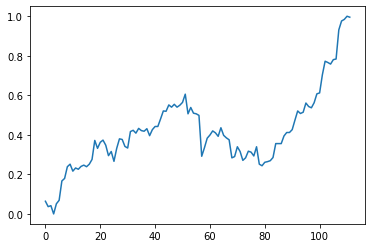

In [38]:
plt.plot( _inputs )

In [39]:
X_test = []
for index in range( 90, 112):
    X_test.append( _inputs[index - 90: index, 0])
X_test = np.array( X_test )

In [40]:
X_test[ 21 ]

array([0.37339744, 0.34775641, 0.29487179, 0.31570513, 0.26602564,
       0.33173077, 0.37980769, 0.37660256, 0.34134615, 0.33333333,
       0.41666651, 0.42307692, 0.40865385, 0.43269231, 0.42147436,
       0.41826907, 0.43108958, 0.39583333, 0.42628221, 0.44230785,
       0.44230785, 0.48076939, 0.52083349, 0.51923077, 0.55128189,
       0.5400641 , 0.55448718, 0.5400641 , 0.54967933, 0.5641024 ,
       0.60576907, 0.50641042, 0.53846138, 0.50961522, 0.50641042,
       0.49839728, 0.29166667, 0.3349359 , 0.38301282, 0.39903846,
       0.41987179, 0.41025641, 0.39262821, 0.43589744, 0.3974359 ,
       0.38461538, 0.375     , 0.28365385, 0.2900641 , 0.33974359,
       0.31570513, 0.27083333, 0.28365385, 0.31730769, 0.3125    ,
       0.29326923, 0.33974359, 0.25160256, 0.24358974, 0.26121795,
       0.26442308, 0.26923077, 0.28525641, 0.35576923, 0.35576923,
       0.35576923, 0.39423077, 0.41185897, 0.41185897, 0.42628221,
       0.47435897, 0.52083349, 0.50801298, 0.51442308, 0.56089

In [41]:
X_test = torch.tensor( X_test, device= device, dtype= torch.float32 )

In [63]:
X_test

tensor([[0.0641, 0.0369, 0.0417,  ..., 0.3942, 0.4119, 0.4119],
        [0.0369, 0.0417, 0.0000,  ..., 0.4119, 0.4119, 0.4263],
        [0.0417, 0.0000, 0.0513,  ..., 0.4119, 0.4263, 0.4744],
        ...,
        [0.3317, 0.3622, 0.3734,  ..., 0.7837, 0.9311, 0.9760],
        [0.3622, 0.3734, 0.3478,  ..., 0.9311, 0.9760, 0.9840],
        [0.3734, 0.3478, 0.2949,  ..., 0.9760, 0.9840, 1.0000]])

In [51]:
regressor.eval()
forecasts = regressor.forward( X_test )

In [71]:
forecasts

array([[16.114758],
       [16.206306],
       [16.514925],
       [16.824743],
       [16.75513 ],
       [16.796396],
       [17.074692],
       [16.960693],
       [16.94091 ],
       [17.08831 ],
       [17.371614],
       [17.416775],
       [18.012562],
       [18.406364],
       [18.428457],
       [18.419966],
       [18.506016],
       [18.497438],
       [19.248255],
       [19.493021],
       [19.695438],
       [19.79229 ]], dtype=float32)

In [53]:
forecasts.shape

torch.Size([22, 1])

In [54]:
forecasts = forecasts.detach().cpu().numpy().reshape(-1,1)


In [55]:
forecasts = normalizador.inverse_transform( forecasts )

In [76]:
forecasts.mean()

17.752956

In [77]:
real_price_test.mean()

17.87454563636364

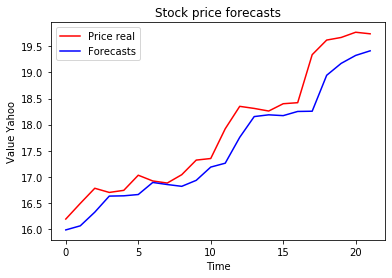

In [54]:
plt.plot( real_price_test, color='red', label='Price real')
plt.plot(forecasts, color = 'blue', label='Forecasts')
plt.title('Stock price forecasts')
plt.xlabel('Time')
plt.ylabel('Value Yahoo')
plt.legend()

In [78]:
torch.save(regressor.state_dict(), 'checkpoint.pth')